<a href="https://colab.research.google.com/github/gabrielbklopes/KFSimulationTest/blob/main/KFSimulationTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install haversine

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from numpy import genfromtxt
from scipy.linalg import expm, block_diag, inv, randn
from haversine import haversine, Unit

from google.colab import files
uploded = files.upload()
file = open('dados_gps_tomas.csv')
my_data = np.loadtxt('dados_gps_tomas.csv', delimiter=',')
print(len(my_data))

Saving dados_gps_tomas.csv to dados_gps_tomas (3).csv
{'dados_gps_tomas.csv': b'-20.176390,-40.222882,0.643056,0.27\r\n-20.176390,-40.222882,0.643056,0.10\r\n-20.176390,-40.222882,0.643056,0.34\r\n-20.176390,-40.222882,0.643056,0.08\r\n-20.176390,-40.222882,0.643056,0.13\r\n-20.176390,-40.222882,0.643056,0.28\r\n-20.176390,-40.222882,0.643056,0.09\r\n-20.176390,-40.222882,0.643056,0.29\r\n-20.176390,-40.222882,0.643056,0.20\r\n-20.176390,-40.222882,0.643056,0.25\r\n-20.176329,-40.222913,2.021767,0.26\r\n-20.176329,-40.222913,2.021767,0.03\r\n-20.176329,-40.222913,2.021767,0.29\r\n-20.176329,-40.222913,2.021767,0.15\r\n-20.176329,-40.222913,2.021767,0.18\r\n-20.176329,-40.222913,2.021767,0.27\r\n-20.176329,-40.222913,2.021767,0.04\r\n-20.176329,-40.222913,2.021767,0.40\r\n-20.176329,-40.222913,2.021767,0.08\r\n-20.176329,-40.222913,2.021767,0.35\r\n-20.176329,-40.222913,2.021767,0.22\r\n-20.176329,-40.222913,2.021767,0.16\r\n-20.176329,-40.222913,2.021767,0.20\r\n-20.176329,-40.222913,2

In [ ]:
def order_by_derivative(Q, dim, block_size):
    N = dim * block_size
    D = zeros((N, N))
    Q = array(Q)
    for i, x in enumerate(Q.ravel()):
        f = eye(block_size) * x
        ix, iy = (i // dim) * block_size, (i % dim) * block_size
        D[ix:ix+block_size, iy:iy+block_size] = f
    return 

def Q_discrete_white_noise(dim, dt=1., var=1., block_size=1, order_by_dim=True):
    if dim not in [2, 3, 4]:
        raise ValueError("dim must be between 2 and 4")
    if dim == 2:
        Q = [[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]]
    elif dim == 3:
        Q = [[.25*dt**4, .5*dt**3, .5*dt**2],
             [ .5*dt**3,    dt**2,       dt],
             [ .5*dt**2,       dt,        1]]
    else:
        Q = [[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
             [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
             [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
             [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]]
    if order_by_dim:
        return block_diag(*[Q]*block_size) * var
    return order_by_derivative(array(Q), dim, block_size) * var

In [ ]:


def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    brng = numpy.arctan2(x,y)
    brng = numpy.degrees(brng)

    return brng

def getNorthish(lat1, long1, lat2, long2):
  pos1 = (lat1, long1)
  pos2 = (lat2, long2)

  aN = haversine(pos1, pos2)*1000
  bN = get_bearing(lat1, long1, lat2, long2)

  return (aN, bN)

def getEasthish(lat1, long1, lat2, long2):
  pos1 = (lat1, long1)
  pos2 = (lat2, long2)

  aE = haversine(pos1, pos2)*1000
  bE = get_bearing(lat1, long1, lat2, long2)

  return(aE, bE)


In [ ]:
def predict(x, P, F, Q, B, u):
  x = F @ x + B @ u
  P =  F @ P @ F.T + Q
  return x, P

def update(x, P, H, R, z):
  S = H @ P @ H.T + R
  K = P @ H.T @ inv(S)
  
  y = z - (H @ x).T
  x += K @ y.T
  P = P - K @ H @ P
  return x, P

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in true_divide


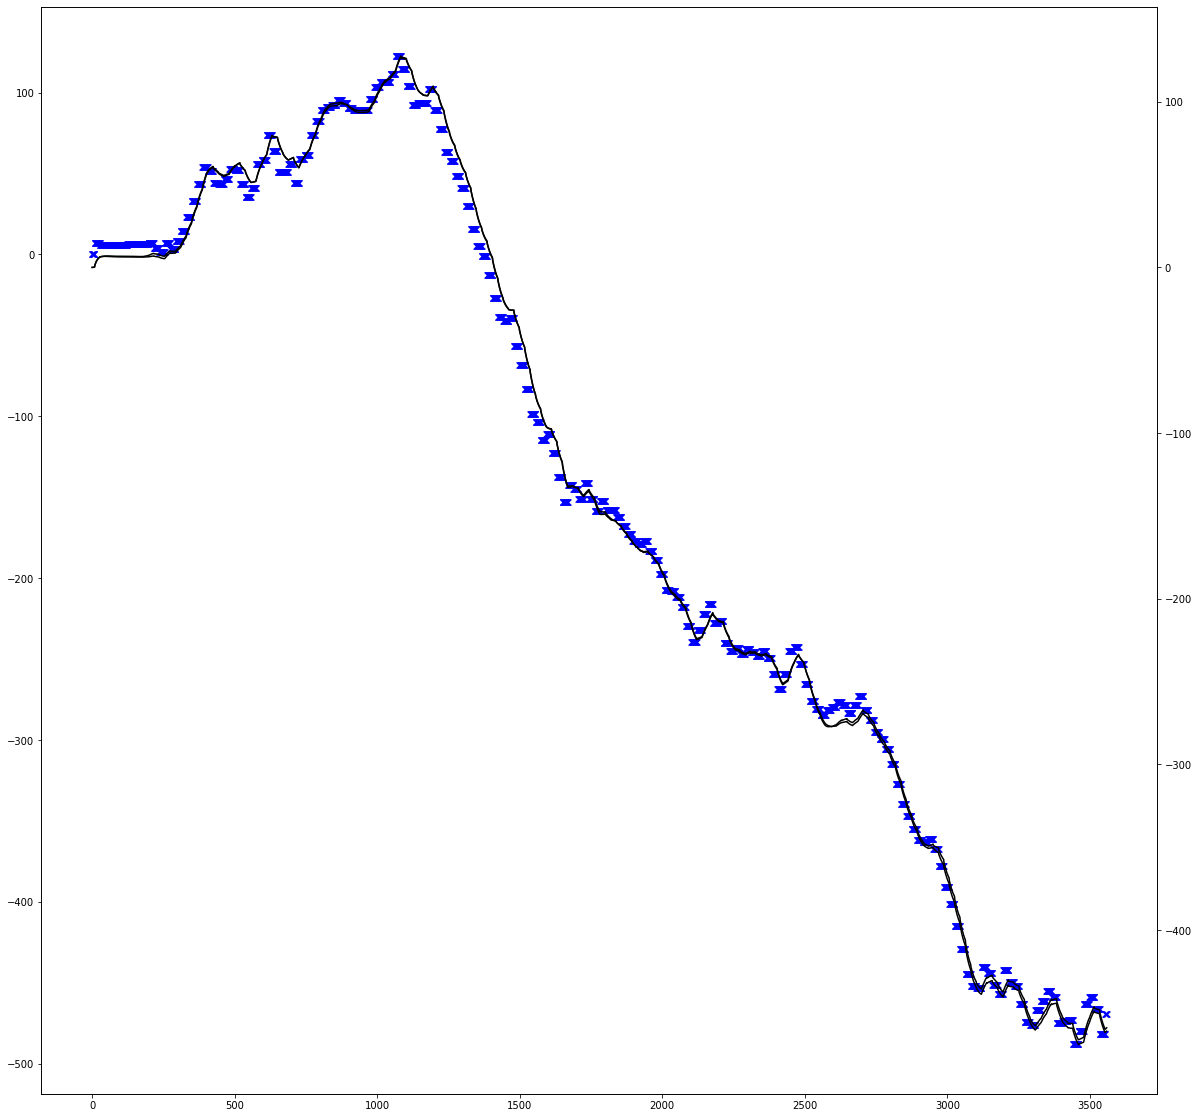

<Figure size 432x288 with 0 Axes>

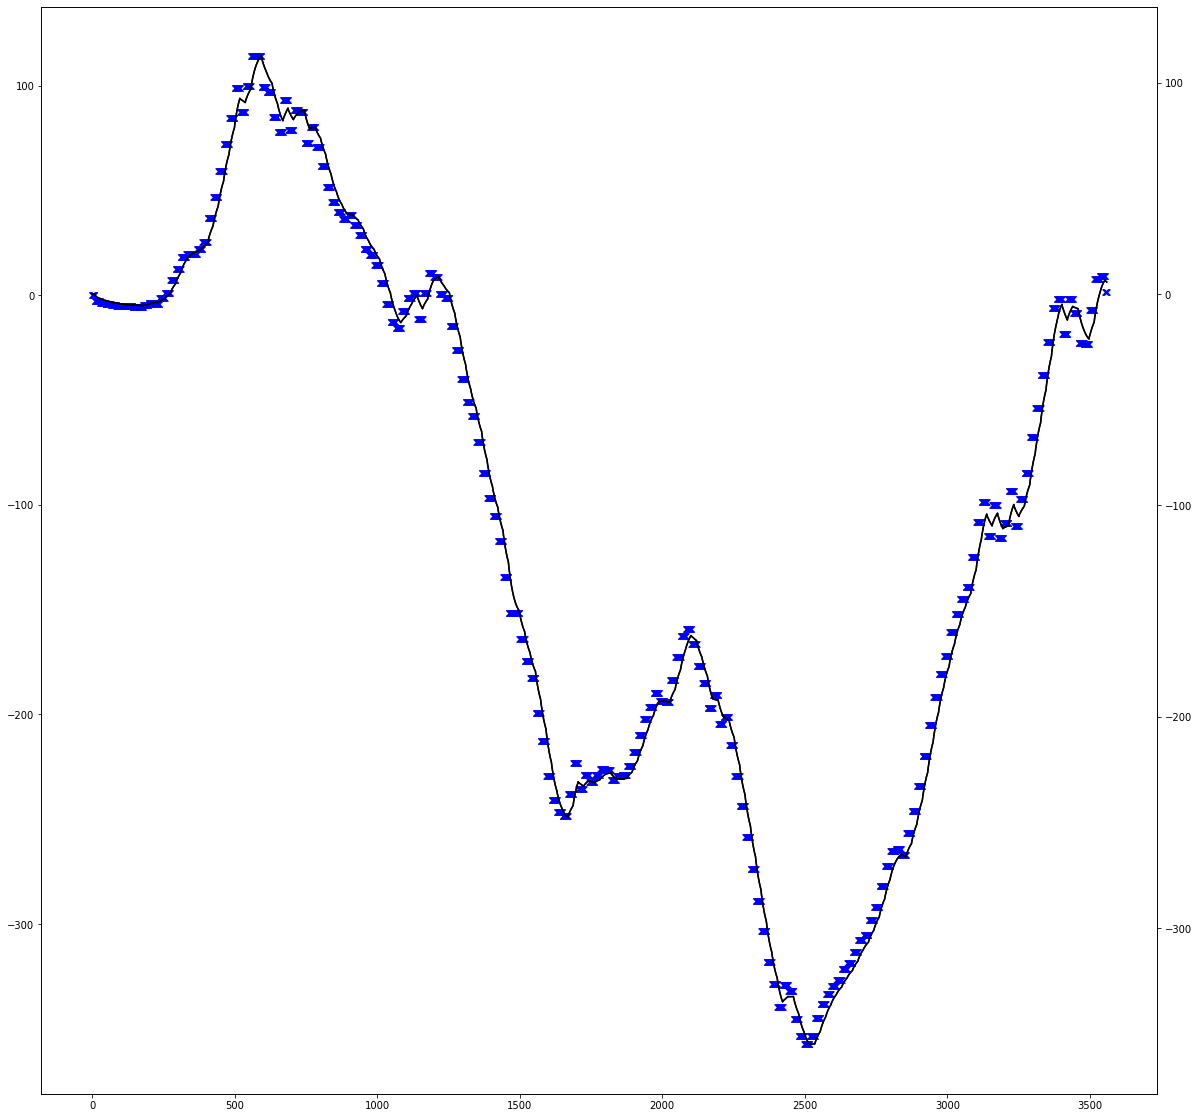

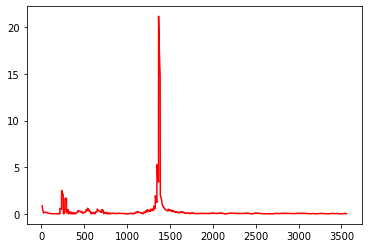

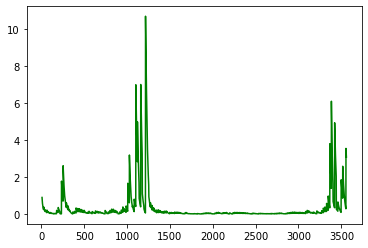

In [ ]:
dt = 0.05

#design state transition function
F = np.array([[1, dt],
              [0,  1]])

B = np.array([[(dt**2)/2],
              [dt]])

H = np.array([[1., 0],
              [0, 1.]])

R = np.array([[10, 0.],
             [0., 10]])

x_N = np.array([[0., 0.]]).T
x_E = np.array([[0., 0.]]).T

P_N = np.diag([100., 100.])
P_E = np.diag([100., 100.])

# DEFINE Q MATRIX
Q = Q_discrete_white_noise(dim=2, dt=dt, var=10)
#Q = block_diag(Q, Q)


measuN, xsN, covN, erroN = [], [], [], []
errN = 0

measuE, xsE, covE, erroE = [], [], [], []
errE = 0


i = 1
N = 0
E = 0

while(i < len(my_data)):
  for j in range(2):
    if j == 0:
      Nmod, Nangle = getNorthish(my_data[i-1, 0], my_data[i-1, 1], my_data[i, 0], my_data[i, 1])
      Ndist = Nmod*math.cos(Nangle)
      N += Ndist
      vN = my_data[i, 2]*math.cos(Nangle)
      aN = np.array([my_data[i, 3]*math.cos(Nangle)])
      z = (N, vN)
      x_N, P_N = predict(x_N, P_N, F, Q, B, aN)
      x_N, P_N = update(x_N, P_N, H, R, z)
      
      #print(x_N)

      measuN.append(z)
      xsN.append(x_N)
      covN.append(P_N)

      errN = abs((x_N[0] - z)/z)
      erroN.append(errN)

    else:
      Emod, Eangle = getEasthish(my_data[i-1, 0], my_data[i-1, 1], my_data[i, 0], my_data[i, 1])
      Edist = Emod*math.sin(Eangle)
      E += Edist
      vE = my_data[i, 2]*math.sin(Nangle)
      aE = np.array([my_data[i, 3]*math.sin(Nangle)])
      z = (E, vE)
      x_E, P_E = predict(x_E, P_E, F, Q, B, aE)
      x_E, P_E = update(x_E, P_E, H, R, z)

      #print(x_E)

      measuE.append(z)
      xsE.append(x_E)
      covE.append(P_E)

      errE = abs((x_E[0] - z)/z)
      erroE.append(errE)

  i += 1


measuN = np.asarray(measuN)
xsN = np.asarray(xsN)
covN = np.asarray(covN)

measuE = np.asarray(measuE)
xsE = np.asarray(xsE)
covE = np.asarray(covE)



In [ ]:
fig,ax = plt.subplots()
ax.plot(measuN[:, 0], "x" ,color="blue")
ax2=ax.twinx()
ax2.plot(xsN[:,0] , color="black")
fig.set_figwidth(15)
fig.set_figheight(15)
plt.show

plt.figure(2)
fig,ax = plt.subplots()
ax.plot(measuE[:, 0] ,"x", color="blue")
ax2=ax.twinx()
ax2.plot(xsE[:,0] , color="black")
fig.set_figwidth(15)
fig.set_figheight(15)
plt.show

erroN = np.asarray(erroN, dtype=np.float32)
erroE = np.asarray(erroE, dtype=np.float32)

plt.figure(3)
fig,ax = plt.subplots()
ax.plot(erroN[:,0], color="red")

plt.figure(3)
fig,ax = plt.subplots()
ax.plot(erroE[:,0], color="green")

[[1.05867736e-01 7.06981301e-01]
 [1.06776059e+00 1.00369525e+00]
 [8.26766253e-01 3.95857602e-01]
 [6.36941135e-01 2.22294062e-01]
 [6.14859998e-01 3.87083578e+00]
 [2.98722684e-01 2.67986560e+00]
 [5.69519460e-01 1.09075356e+00]
 [6.16948032e+00 5.94694018e-01]
 [1.48155630e+00 1.35335684e-01]
 [2.23700547e+00 1.58924568e+00]
 [6.50175691e-01 7.46677876e-01]
 [8.44503224e-01 1.72782704e-01]
 [8.00401866e-01 1.02347603e+01]
 [1.79362759e-01 1.12720776e+00]
 [3.68169174e+01 4.44345236e-01]
 [3.23617935e+00 1.69594967e+00]
 [1.35481684e-02 6.01725280e-01]
 [3.23304027e-01 8.06272924e-01]
 [3.32333207e+00 1.45873296e+00]
 [4.18993503e-01 6.94493175e-01]
 [5.83810747e-01 3.73206317e-01]
 [5.92570007e-01 3.85363370e-01]
 [5.30124724e-01 1.54587519e+00]
 [1.24061489e+00 9.59163725e-01]
 [2.44737291e+00 5.15784919e-01]
 [1.00837791e+00 1.79171637e-01]
 [8.80067408e-01 1.00957613e+01]
 [2.96735883e-01 1.17291653e+00]
 [1.32367164e-01 6.43979728e-01]
 [2.38377243e-01 1.68894064e+00]
 [1.287510